In [ ]:
# # For Google Colaboratory
# import sys, os
# if 'google.colab' in sys.modules:
#     # mount google drive
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     # find automatically the path of the folder containing "file_name" :
#     file_name = 'AI6128_Code_a.ipynb'
#     import subprocess
#     path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
#     path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
#     print(path_to_file)
#     # change current path to the folder containing "file_name"
#     os.chdir(path_to_file)
#     !pwd


Mounted at /content/gdrive
./gdrive/MyDrive/UC/
/content/gdrive/MyDrive/UC


### compute_f.py: For calculating step positions

In [ ]:
import numpy as np
import scipy.signal as signal

def split_ts_seq(ts_seq, sep_ts):
    """ :param  ts_seq : data array
        :param  sep_ts : unique time stamp array
        :return ts_seqs: sorted unique time stamp"""
    
    tss           = ts_seq[ : , 0].astype(float)
    unique_sep_ts = np.unique(sep_ts)
    ts_seqs       = []
    start_index   = 0
    
    for i in range(0, unique_sep_ts.shape[0]):
        end_index = np.searchsorted(tss, unique_sep_ts[i], side = 'right')
        
        if start_index == end_index:
            continue
            
        ts_seqs.append(ts_seq[start_index : end_index, : ].copy())
        start_index = end_index

    # tail data
    if start_index < ts_seq.shape[0]:
        ts_seqs.append(ts_seq[start_index : , : ].copy())

    return ts_seqs

def correct_trajectory(original_xys, end_xy):
    """ :param  original_xys : numpy ndarray, shape(N, 2)
        :param  end_xy       : numpy ndarray, shape(1, 2)
        :return corrected_xys: """
    
    corrected_xys = np.zeros((0, 2))
    A             = original_xys[0, : ]
    B             = end_xy
    Bp            = original_xys[-1, : ]
    angle_BAX     = np.arctan2(B[1] - A[1], B[0] - A[0])
    angle_BpAX    = np.arctan2(Bp[1] - A[1], Bp[0] - A[0])
    angle_BpAB    = angle_BpAX - angle_BAX
    AB            = np.sqrt(np.sum((B - A) ** 2))
    ABp           = np.sqrt(np.sum((Bp - A) ** 2))
    corrected_xys = np.append(corrected_xys, [A], 0)
    
    for i in np.arange(1, np.size(original_xys, 0)):
        angle_CpAX    = np.arctan2(original_xys[i, 1] - A[1], original_xys[i, 0] - A[0])
        angle_CAX     = angle_CpAX - angle_BpAB
        ACp           = np.sqrt(np.sum((original_xys[i, : ] - A) ** 2))
        AC            = ACp * AB / ABp
        delta_C       = np.array([AC * np.cos(angle_CAX), AC * np.sin(angle_CAX)])
        C             = delta_C + A
        corrected_xys = np.append(corrected_xys, [C], 0)

    return corrected_xys

def correct_positions(rel_positions, reference_positions):
    """ :param rel_positions:       relative position
        :param reference_positions: ground truth position
        :return:                    corrected_positions """
    
    rel_positions_list = split_ts_seq(rel_positions, reference_positions[: , 0])
    
    if len(rel_positions_list) != reference_positions.shape[0] - 1:
        # print(f'Rel positions list size: {len(rel_positions_list)}, ref positions size: {reference_positions.shape[0]}')
        del rel_positions_list[-1]
        
    assert len(rel_positions_list) == reference_positions.shape[0] - 1
    corrected_positions            = np.zeros((0, 3))
    
    for i, rel_ps in enumerate(rel_positions_list):
        start_position   = reference_positions[i]
        end_position     = reference_positions[i + 1]
        abs_ps           = np.zeros(rel_ps.shape)
        abs_ps[: , 0]    = rel_ps[ : , 0]
        # abs_ps[:, 1:3] = rel_ps[:, 1:3] + start_position[1:3]
        abs_ps[0, 1 : 3] = rel_ps[0, 1 : 3] + start_position[1 : 3]
        
        for j in range(1, rel_ps.shape[0]):
            abs_ps[j, 1 : 3] = abs_ps[j - 1, 1 : 3] + rel_ps[j, 1 : 3]
            
        abs_ps        = np.insert(abs_ps, 0, start_position, axis = 0)
        corrected_xys = correct_trajectory(abs_ps[ : , 1 : 3], end_position[1 : 3])
        corrected_ps  = np.column_stack((abs_ps[ : , 0], corrected_xys))
        
        if i == 0:
            corrected_positions = np.append(corrected_positions, corrected_ps, axis = 0)
        else:
            corrected_positions = np.append(corrected_positions, corrected_ps[1 : ], axis = 0)

    corrected_positions = np.array(corrected_positions)

    return corrected_positions

def init_parameters_filter(sample_freq, warmup_data, cut_off_freq = 2):
    ''''''
    
    order              = 4
    filter_b, filter_a = signal.butter(order, cut_off_freq / (sample_freq / 2), 'low', False)
    zf                 = signal.lfilter_zi(filter_b, filter_a)
    _, zf              = signal.lfilter(filter_b, filter_a, warmup_data, zi = zf)
    _, filter_zf       = signal.lfilter(filter_b, filter_a, warmup_data, zi = zf)

    return filter_b, filter_a, filter_zf

def get_rotation_matrix_from_vector(rotation_vector):
    ''''''
    
    q1 = rotation_vector[0]
    q2 = rotation_vector[1]
    q3 = rotation_vector[2]

    if rotation_vector.size >= 4:
        q0 = rotation_vector[3]
    else:
        q0 = 1 - q1 * q1 - q2 * q2 - q3 * q3
        
        if q0 > 0:
            q0 = np.sqrt(q0)
        else:
            q0 = 0

    sq_q1 = 2 * q1 * q1
    sq_q2 = 2 * q2 * q2
    sq_q3 = 2 * q3 * q3
    q1_q2 = 2 * q1 * q2
    q3_q0 = 2 * q3 * q0
    q1_q3 = 2 * q1 * q3
    q2_q0 = 2 * q2 * q0
    q2_q3 = 2 * q2 * q3
    q1_q0 = 2 * q1 * q0
    R     = np.zeros((9,))
    
    if R.size == 9:
        R[0] = 1 - sq_q2 - sq_q3
        R[1] = q1_q2 - q3_q0
        R[2] = q1_q3 + q2_q0
        R[3] = q1_q2 + q3_q0
        R[4] = 1 - sq_q1 - sq_q3
        R[5] = q2_q3 - q1_q0
        R[6] = q1_q3 - q2_q0
        R[7] = q2_q3 + q1_q0
        R[8] = 1 - sq_q1 - sq_q2
        R    = np.reshape(R, (3, 3))
    elif R.size == 16:
        R[0]  = 1 - sq_q2 - sq_q3
        R[1]  = q1_q2 - q3_q0
        R[2]  = q1_q3 + q2_q0
        R[3]  = 0.0
        R[4]  = q1_q2 + q3_q0
        R[5]  = 1 - sq_q1 - sq_q3
        R[6]  = q2_q3 - q1_q0
        R[7]  = 0.0
        R[8]  = q1_q3 - q2_q0
        R[9]  = q2_q3 + q1_q0
        R[10] = 1 - sq_q1 - sq_q2
        R[11] = 0.0
        R[12] = R[13] = R[14] = 0.0
        R[15] = 1.0
        R     = np.reshape(R, (4, 4))

    return R

def get_orientation(R):
    ''''''
    
    flat_R = R.flatten()
    values = np.zeros((3, ))
    
    if np.size(flat_R) == 9:
        values[0] = np.arctan2(flat_R[1], flat_R[4])
        values[1] = np.arcsin(-flat_R[7])
        values[2] = np.arctan2(-flat_R[6], flat_R[8])
    else:
        values[0] = np.arctan2(flat_R[1], flat_R[5])
        values[1] = np.arcsin(-flat_R[9])
        values[2] = np.arctan2(-flat_R[8], flat_R[10])

    return values

def compute_steps(acce_datas):
    '''calculate steps based on accelerometer (acceleration)
       return step_timestamps, step_indexs, step_acce_max_mins'''
    
    step_timestamps               = np.array([])
    step_indexs                   = np.array([], dtype = int)
    step_acce_max_mins            = np.zeros((0, 4))
    sample_freq                   = 50
    window_size                   = 22
    low_acce_mag                  = 0.6
    step_criterion                = 1
    interval_threshold            = 250
    acce_max                      = np.zeros((2, ))
    acce_min                      = np.zeros((2, ))
    acce_binarys                  = np.zeros((window_size, ), dtype = int)
    acce_mag_pre                  = 0
    state_flag                    = 0
    warmup_data                   = np.ones((window_size, )) * 9.81
    filter_b, filter_a, filter_zf = init_parameters_filter(sample_freq, warmup_data)
    acce_mag_window               = np.zeros((window_size, 1))

    # detect steps according to acceleration magnitudes
    for i in np.arange(0, np.size(acce_datas, 0)):
        acce_data                = acce_datas[i, : ]
        acce_mag                 = np.sqrt(np.sum(acce_data[1 : ] ** 2))
        acce_mag_filt, filter_zf = signal.lfilter(filter_b, filter_a, [acce_mag], zi = filter_zf)
        acce_mag_filt            = acce_mag_filt[0]
        acce_mag_window          = np.append(acce_mag_window, [acce_mag_filt])
        acce_mag_window          = np.delete(acce_mag_window, 0)
        mean_gravity             = np.mean(acce_mag_window)
        acce_std                 = np.std(acce_mag_window)
        mag_threshold            = np.max([low_acce_mag, 0.4 * acce_std])
        # detect valid peak or valley of acceleration magnitudes
        acce_mag_filt_detrend    = acce_mag_filt - mean_gravity
        
        if acce_mag_filt_detrend > np.max([acce_mag_pre, mag_threshold]):
            # peak
            acce_binarys = np.append(acce_binarys, [1])
            acce_binarys = np.delete(acce_binarys, 0)
        elif acce_mag_filt_detrend < np.min([acce_mag_pre, -mag_threshold]):
            # valley
            acce_binarys = np.append(acce_binarys, [-1])
            acce_binarys = np.delete(acce_binarys, 0)
        else:
            # between peak and valley
            acce_binarys = np.append(acce_binarys, [0])
            acce_binarys = np.delete(acce_binarys, 0)

        if (acce_binarys[-1] == 0) and (acce_binarys[-2] == 1):
            if state_flag == 0:
                acce_max[ : ] = acce_data[0], acce_mag_filt
                state_flag    = 1
            elif (state_flag == 1) and \
                 ((acce_data[0] - acce_max[0]) <= interval_threshold) and \
                 (acce_mag_filt > acce_max[1]):
                acce_max[ : ] = acce_data[0], acce_mag_filt
            elif (state_flag == 2) and \
                 ((acce_data[0] - acce_max[0]) > interval_threshold):
                acce_max[ : ] = acce_data[0], acce_mag_filt
                state_flag    = 1

        # choose reasonable step criterion and check if there is a valid step
        # save step acceleration data: step_acce_max_mins = [timestamp, max, min, variance]
        step_flag = False
        
        if step_criterion == 2:
            if (acce_binarys[-1] == -1) and ((acce_binarys[-2] == 1) or \
                                             (acce_binarys[-2] == 0)):
                step_flag = True
        elif step_criterion == 3:
            if (acce_binarys[-1] == -1) and (acce_binarys[-2] == 0) and \
                (np.sum(acce_binarys[ : -2]) > 1):
                step_flag = True
        else:
            if (acce_binarys[-1] == 0) and acce_binarys[-2] == -1:
                if (state_flag == 1) and ((acce_data[0] - acce_min[0]) > interval_threshold):
                    acce_min[ : ] = acce_data[0], acce_mag_filt
                    state_flag    = 2
                    step_flag     = True
                elif (state_flag == 2) and ((acce_data[0] - acce_min[0]) <= interval_threshold) and \
                      (acce_mag_filt < acce_min[1]):
                    acce_min[ : ] = acce_data[0], acce_mag_filt
                    
        if step_flag:
            step_timestamps    = np.append(step_timestamps, acce_data[0])
            step_indexs        = np.append(step_indexs, [i])
            step_acce_max_mins = np.append(step_acce_max_mins,
                                           [[acce_data[0], acce_max[1], 
                                             acce_min[1], acce_std ** 2]],
                                           axis = 0)
            
        acce_mag_pre = acce_mag_filt_detrend

    return step_timestamps, step_indexs, step_acce_max_mins

def compute_stride_length(step_acce_max_mins):
    '''calculate stride length based on accelerotion max min
       return stride_lengths'''
    
    K                      = 0.4
    K_max                  = 0.8
    K_min                  = 0.4
    para_a0                = 0.21468084
    para_a1                = 0.09154517
    para_a2                = 0.02301998
    stride_lengths         = np.zeros((step_acce_max_mins.shape[0], 2))
    k_real                 = np.zeros((step_acce_max_mins.shape[0], 2))
    step_timeperiod        = np.zeros((step_acce_max_mins.shape[0] - 1, ))
    stride_lengths[ : , 0] = step_acce_max_mins[ : , 0]
    window_size            = 2
    step_timeperiod_temp   = np.zeros((0, ))

    # calculate every step period - step_timeperiod unit: second
    for i in range(0, step_timeperiod.shape[0]):
        step_timeperiod_data = (step_acce_max_mins[i + 1, 0] - step_acce_max_mins[i, 0]) / 1000
        step_timeperiod_temp = np.append(step_timeperiod_temp, [step_timeperiod_data])
        
        if step_timeperiod_temp.shape[0] > window_size:
            step_timeperiod_temp = np.delete(step_timeperiod_temp, [0])
            
        step_timeperiod[i] = np.sum(step_timeperiod_temp) / step_timeperiod_temp.shape[0]

    # calculate parameters by step period and acceleration magnitude variance
    k_real[ : , 0] = step_acce_max_mins[ : , 0]
    k_real[0, 1]   = K
    
    for i in range(0, step_timeperiod.shape[0]):
        k_real[i + 1, 1] = np.max([(para_a0 + para_a1 / step_timeperiod[i] +
                                    para_a2 * step_acce_max_mins[i, 3]), 
                                   K_min])
        k_real[i + 1, 1] = np.min([k_real[i + 1, 1], K_max]) * (K / K_min)

    # calculate every stride length by parameters and max and min data of acceleration magnitude
    stride_lengths[ : , 1] = np.max([(step_acce_max_mins[ : , 1] - step_acce_max_mins[ : , 2]),
                                    np.ones((step_acce_max_mins.shape[0], ))], 
                                    axis=0) ** (1 / 4) * k_real[ : , 1]

    return stride_lengths

def compute_headings(ahrs_datas):
    '''calculate heading from rotation vectors
       return headings'''
    
    noRotVecElem = np.size(ahrs_datas, 0)
    headings     = np.zeros((noRotVecElem, 2))
    
    for i in np.arange(0, noRotVecElem):
        ahrs_data            = ahrs_datas[i, : ]
        rot_matrix           = get_rotation_matrix_from_vector(ahrs_data[1 : ])
        azimuth, pitch, roll = get_orientation(rot_matrix)
        around_z             = (-azimuth) % (2 * np.pi)
        headings[i,  : ]     = ahrs_data[0], around_z
        
    return headings

def compute_step_heading(step_timestamps, headings):
    '''calculate step's headomg based on time stamp and headings 
       return step_headings'''
    
    step_headings         = np.zeros((len(step_timestamps), 2))
    step_timestamps_index = 0
    
    for i in range(0, len(headings)):
        if step_timestamps_index < len(step_timestamps):
            if headings[i, 0] == step_timestamps[step_timestamps_index]:
                step_headings[step_timestamps_index, : ] = headings[i, : ]
                step_timestamps_index += 1
        else:
            break
            
    assert step_timestamps_index == len(step_timestamps)

    return step_headings

def compute_rel_positions(stride_lengths, step_headings):
    '''calculate relative positions based on stride lengths and step headings
       return rel_positions'''
    
    rel_positions = np.zeros((stride_lengths.shape[0], 3))
    
    for i in range(0, stride_lengths.shape[0]):
        rel_positions[i, 0] = stride_lengths[i, 0]
        rel_positions[i, 1] = -stride_lengths[i, 1] * np.sin(step_headings[i, 1])
        rel_positions[i, 2] = stride_lengths[i, 1] * np.cos(step_headings[i, 1])

    return rel_positions

def compute_step_positions(acce_datas, ahrs_datas, posi_datas):
    '''calculate the step positions based on accelerometer, rotation vector, waypoint
       return step positions'''
    
    step_timestamps, step_indexs, step_acce_max_mins = compute_steps(acce_datas)
    headings                                         = compute_headings(ahrs_datas)
    stride_lengths                                   = compute_stride_length(step_acce_max_mins)
    step_headings                                    = compute_step_heading(step_timestamps, headings)
    rel_positions                                    = compute_rel_positions(stride_lengths, step_headings)
    step_positions                                   = correct_positions(rel_positions, posi_datas)

    return step_positions

### main routine:

In [ ]:
import json
import os
from pathlib import Path
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


siteFloor                    = '/site1/F1'             ##### Change this line to choose which floor to visualize
floorPath                    = './data'  + siteFloor
pathDataDir                  = floorPath + '/path_data_files'
floorPlanFile                = floorPath + '/floor_image.png'
floorInfoFile                = floorPath + '/floor_info.json'
outputDir                    = './output'+ siteFloor
pathImageOutputDir           = outputDir + '/path_images'
stepPosImageOutputDir        = outputDir + '/step_positions'
magnImageOutputdir           = outputDir + '/magnetic_images'
wifiImageOutputdir           = outputDir + '/wifi_images'
       
Path(pathImageOutputDir).mkdir(parents = True, exist_ok = True)
Path(stepPosImageOutputDir).mkdir(parents = True, exist_ok = True)
Path(magnImageOutputdir).mkdir(parents = True, exist_ok = True)
Path(wifiImageOutputdir).mkdir(parents = True, exist_ok = True)

with open(floorInfoFile) as f:
    floorInfo = json.load(f)
    
width_meter    = floorInfo["map_info"]["width"]
height_meter   = floorInfo["map_info"]["height"]
path_filenames = list(Path(pathDataDir).resolve().glob("*.txt"))

### essential task 1
### visualize waypoints


In [ ]:
#Get way point data

def getWayPoints(dataFile):
  
  waypoints    = []

  with open(dataFile, 'r', encoding = 'utf-8') as file:
    lines = file.readlines()

    for line_data in lines:
      line_data = line_data.strip()
     
      if not line_data or line_data[0] == '#':
          continue

      line_data = line_data.split('\t')

      if line_data[1] == 'TYPE_WAYPOINT':
          waypoints.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

  waypoints = np.array(waypoints)

  return waypoints


In [ ]:
# ######### Plot individual waypoints #############

# for path_filename in path_filenames:
#   #Read in floor image
#   image = plt.imread(floorPlanFile)
#   implot = plt.imshow(image)

#   #Scaling for superimposing of floorplan
#   scaleFactor = (image.shape[0] / height_meter + image.shape[1] / width_meter)/2
  
#   path_data     = getWayPoints(path_filename)
#   path_id       = path_filename.name.split(".")[0]

#   #Get x and y coordinates
#   x = path_data[:,1]
#   y = path_data[:,2]
#   x, y = np.array(x), np.array(y)

#   #Scale coordinates for superimposing
#   x, y = x * scaleFactor, image.shape[0] - y * scaleFactor

#   plt.scatter(x,y, s = 5)
#   plt.plot(x,y)

#   #Save plot
#   png_filename = f'{pathImageOutputDir}/{path_id}.png'
#   png_filename = str(Path(png_filename).resolve())
#   plt.savefig(png_filename)

#   plt.clf()

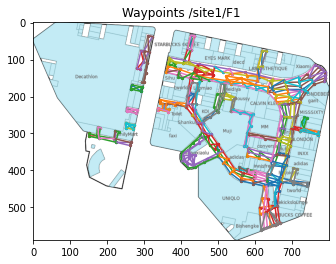

In [ ]:
######### Plot all waypoints in one image #############

#Read in floor image
image = plt.imread(floorPlanFile)
implot = plt.imshow(image)
plt.title(label =  'Waypoints ' + siteFloor)

#Scaling for superimposing of floorplan
scaleFactor = (image.shape[0] / height_meter + image.shape[1] / width_meter)/2

for path_filename in path_filenames:
  path_data     = getWayPoints(path_filename)

  #Get x and y coordinates
  x = path_data[:,1]
  y = path_data[:,2]
  x, y = np.array(x), np.array(y)

  #Scale coordinates for superimposing
  x, y = x * scaleFactor, image.shape[0] - y * scaleFactor

  
  plt.scatter(x,y, s = 5)
  plt.plot(x,y)

#Save plot
plt.savefig(pathImageOutputDir + '/allWaypoints.png')

### step position


In [ ]:
#################### Method to read trace file and return as a AAMWWData object ####################

from dataclasses import dataclass

@dataclass
class AAMWWData:
    acce: np.ndarray
    magn: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    waypoints: np.ndarray

def getAAMWW(dataFile):

    acce = []
    ahrs = []
    magn = []
    wifi = []
    waypoints = []

    with open(dataFile, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        for line in lines:
            line = line.strip()
            if not line or line[0] == '#':
                continue

            line_data = line.split('\t')

            if line_data[1] == 'TYPE_ACCELEROMETER':
                # Unix Time, XYZ
                acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            elif line_data[1] == 'TYPE_ROTATION_VECTOR':
                # Unix Time, XYZ
                ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            elif line_data[1] == 'TYPE_MAGNETIC_FIELD':
                # Unix Time, XYX
                magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            elif line_data[1] == 'TYPE_WIFI':
                 sys_ts      = line_data[0] # system time stamp
                 ssid        = line_data[2] # Service Set IDentifier (network name)
                 bssid       = line_data[3] # Basic Service Set IDentifier (MAC physical address of wireless router/ access pt)
                 rssi        = line_data[4] # Received Signal Strength Indicator (detected signal level)
                 lastseen_ts = line_data[6] # last seen time stamp
                 wifi_data   = [sys_ts, ssid, bssid, rssi, lastseen_ts]
                 wifi.append(wifi_data)
            elif line_data[1] == 'TYPE_WAYPOINT':
                # Unix Time, XY
                waypoints.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

    acce = np.array(acce)
    ahrs = np.array(ahrs)
    magn = np.array(magn)
    wifi = np.array(wifi)
    waypoints = np.array(waypoints)

    return AAMWWData(acce, ahrs, magn, wifi, waypoints)

             

In [ ]:
#################### Method to map magnetic and wifi readings to steps ####################

def magneticWifiToStep(dataFile):

  mwi_datas = {} # dict

  for path_filename in dataFile:
        AAMWW_datas         = getAAMWW(path_filename)        # return AAMWWData object
        acce_datas          = AAMWW_datas.acce               # accelerometer
        ahrs_datas          = AAMWW_datas.ahrs               # rotation vector
        magn_datas          = AAMWW_datas.magn               # magnetic field       
        wifi_datas          = AAMWW_datas.wifi               # wifi
        waypoints_datas     = AAMWW_datas.waypoints           # waypoint
        
        #Calculate step positions using accelerometer, rotation vector and waypoint data
        step_positions = compute_step_positions(acce_datas, ahrs_datas, waypoints_datas)  

      ###################### Mapping wifi readings to step positions ######################
        if wifi_datas.size != 0:
            sep_tss         = np.unique(wifi_datas[ : , 0].astype(float)) # extract unique time stamp
            wifi_datas_list = split_ts_seq(wifi_datas, sep_tss)           #arrange time stamps in sequence
            
            for wifi_ds in wifi_datas_list:

                # Find the time difference between each step positions and the time stamp of the recorded wifi readings
                diff          = np.abs(step_positions[ : , 0] - float(wifi_ds[0, 0])) 

                # Find the index of the step position with the smallest time difference
                index         = np.argmin(diff)

                # Set KEY as the x and y coordinates of step position
                target_xy_key = tuple(step_positions[index, 1 : 3])
                
                if target_xy_key in mwi_datas:
                    # If KEY exists, append wifi readings to it
                    mwi_datas[target_xy_key]['wifi'] = np.append(mwi_datas[target_xy_key]['wifi'], \
                                                                 wifi_ds, axis = 0)
                else:
                    # If KEY does not exist, add new KEY VALUE pair into dictionary
                    mwi_datas[target_xy_key] = {
                        'magnetic': np.zeros((0, 4)),
                        'wifi'    : wifi_ds
                    }

      ###################### Mapping magnetic field readings to step positions ######################
        sep_tss         = np.unique(magn_datas[ : , 0].astype(float)) # extract unique time stamp
        magn_datas_list = split_ts_seq(magn_datas, sep_tss)           #arrange time stamps in sequence
        
        for magn_ds in magn_datas_list:

            # Find the time difference between each step positions and the time stamp of the recorded magnetic field reading
            diff          = np.abs(step_positions[ : , 0] - float(magn_ds[0, 0]))

            # Find the index of the step position with the smallest time difference
            index         = np.argmin(diff)

            # Set KEY as the x and y coordinates of step position
            target_xy_key = tuple(step_positions[index, 1 : 3])
            
            if target_xy_key in mwi_datas:
                # If KEY exists, append magnetic field reading to it
                mwi_datas[target_xy_key]['magnetic'] = np.append(mwi_datas[target_xy_key]['magnetic'], \
                                                                 magn_ds, axis = 0)
            else:
                # If KEY does not exist, add new KEY VALUE pair into dictionary
                mwi_datas[target_xy_key] = {
                    'magnetic': magn_ds,
                    'wifi'    : np.zeros((0, 5))
                }

  return mwi_datas

In [ ]:
# Method to return a dictionary object containing KEY(step position) and VALUE(magnetic strength)
def getMagneticStrength(mwi_datas):

  magneticStrength = {}
    
  for stepPosition in mwi_datas:
    magneticData                   = mwi_datas[stepPosition]['magnetic']

    # magnetic strength is calculated as the mean of the sum of the square root of the sum of the x,y,z coordinates squared
    magneticS                      = np.mean(np.sqrt(np.sum(magneticData[ : , 1 : 4] ** 2, axis = 1)))
    magneticStrength[stepPosition] = magneticS

  return magneticStrength

In [ ]:
# Method to return a dictionary object containing KEY(step position) and VALUE(rssi)
def getWifiRssi(mwi_datas):

    wifi_rssi = {}
    
    for stepPosition in mwi_datas:
        wifi_data = mwi_datas[stepPosition]['wifi']
        
        for wifi_d in wifi_data:
            bssid = wifi_d[2]
            rssi  = int(wifi_d[3])

            # check if KEY(bssid) already exists in wifi_rssi dictionary 
            if bssid in wifi_rssi:                                                       
              position_rssi = wifi_rssi[bssid] 

              # check if KEY(stepPosition) already exists in position_rssi dictionary
              if stepPosition in position_rssi:                                                   
                  old_rssi                       = position_rssi[stepPosition][0]
                  old_count                      = position_rssi[stepPosition][1]
                  position_rssi[stepPosition][0] = (old_rssi * old_count + rssi) / (old_count + 1)   # to find the mean rssi for that stepPosition
                  position_rssi[stepPosition][1] = old_count + 1

              # if KEY(stepPosition) does not exists in position_rssi dictionary, add new KEY VALUE pair into position_rssi dictionary
              else:
                  position_rssi[stepPosition] = np.array([rssi, 1])

            # if KEY(bssid) does not exists in wifi_rssi dictionary, create position_rssi dictionary and add new KEY VALUE pair into position_rssi dictionary       
            else:
              position_rssi               = {}
              position_rssi[stepPosition] = np.array([rssi, 1])
            
            # update wifi_rssi dictionary
            wifi_rssi[bssid] = position_rssi

    return wifi_rssi

In [ ]:
###### Method to count instances of data types
count_acce = 0
count_ahrs = 0
count_magn = 0
count_wifi = 0
count_waypoints = 0

for path in path_filenames:
  placeholder = getAAMWW(path)
  count_acce += len(placeholder.acce)
  count_ahrs += len(placeholder.ahrs)
  count_magn += len(placeholder.magn)
  count_wifi += len(placeholder.wifi)
  count_waypoints += len(placeholder.waypoints)

print(count_acce)
print(count_ahrs)
print(count_magn)
print(count_wifi)
print(count_waypoints)

290966
290966
290966
868647
975


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in arcsin


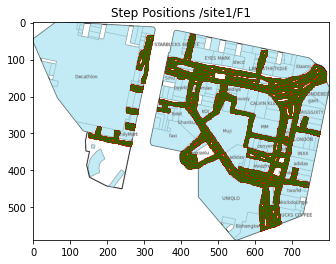

In [ ]:
mwi_datas      = magneticWifiToStep(path_filenames)  # get magnetic field and wifi data
step_positions = np.array(list(mwi_datas.keys()))    # get x y coordinates of step positions

######### Plot step position #############
#Read in floor image
image = plt.imread(floorPlanFile)
implot = plt.imshow(image)
plt.title(label =  'Step Positions ' + siteFloor)

#Scaling for superimposing of floorplan
scaleFactor = (image.shape[0] / height_meter + image.shape[1] / width_meter)/2

for path_filename in path_filenames:
  path_data     = step_positions

  #Get x and y coordinates
  x = path_data[:,0]
  y = path_data[:,1]
  x, y = np.array(x), np.array(y)

  #Scale coordinates for superimposing
  x, y = x * scaleFactor, image.shape[0] - y * scaleFactor

  plt.scatter(x,y,s=2, c = 'g', marker="o",linewidth= 0.1, edgecolor='r' )

#Save plot
plt.savefig(stepPosImageOutputDir + '/stepPositions.png')


### essential task 2
### geomagnetic heat map


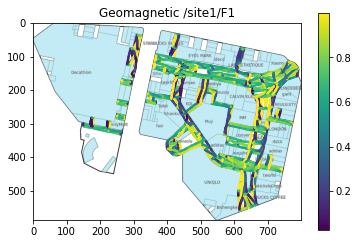

In [ ]:
magneticStrength  = getMagneticStrength(mwi_datas)
heatPositions    = np.array(list(magneticStrength.keys()))
heatValues       = np.array(list(magneticStrength.values()))


######### Plot geomagnetic heat map #############

# Read in floor image
image = plt.imread(floorPlanFile)
implot = plt.imshow(image)
plt.title(label =  'Geomagnetic ' + siteFloor)

# Scaling for superimposing of floorplan
scaleFactor = (image.shape[0] / height_meter + image.shape[1] / width_meter)/2

# Get x and y coordinates
x = heatPositions[:,0]
y = heatPositions[:,1]
x, y = np.array(x), np.array(y)

# Scale coordinates for superimposing
x, y = x * scaleFactor, image.shape[0] - y * scaleFactor

# Lighter hue means stronger magnetic strength, darker hue means weaker magnetic strength
plt.scatter(x,y, s = 2, c = heatValues, cmap = 'viridis')
cBar = plt.colorbar(cmap='viridis')

# Save plot
plt.savefig(magnImageOutputdir + '/geomagneticHeatMap.png')

### essential task 3
### wifi heat map


In [ ]:
import random

random.seed(3)
wifi_rssi       = getWifiRssi(mwi_datas)
wifiCount       = len(wifi_rssi.keys())
print(f'This floor has {wifiCount} wifi aps')
reqNo           = 3 # no. of wifi aps required
i               = 0 # counter

while i < reqNo:
    s              = int(wifiCount * random.random())
    target_wifi    = list(wifi_rssi.keys())[s]
    heatPositions  = np.array(list(wifi_rssi[target_wifi].keys()))
    heatValues     = np.array(list(wifi_rssi[target_wifi].values()))[:, 0]
    plt.clf()

    ######### Plot wifi heat map #############

    # Read in floor image
    image = plt.imread(floorPlanFile)
    implot = plt.imshow(image)

    # Scaling for superimposing of floorplan
    scaleFactor = (image.shape[0] / height_meter + image.shape[1] / width_meter)/2

    # Get x and y coordinates
    x = heatPositions[:,0]
    y = heatPositions[:,1]
    x, y = np.array(x), np.array(y)

    # Scale coordinates for superimposing
    x, y = x * scaleFactor, image.shape[0] - y * scaleFactor

    # Lighter hue means stronger wifi strength, darker hue means weaker wifi strength
    plt.title(label =  'Wi-Fi: ' + target_wifi)
    plt.scatter(x,y, s = 2, c = heatValues, cmap = 'plasma')
    cBar = plt.colorbar(cmap = 'plasma')
    cBar.ax.set_xlabel('dBm')

    # Save plot
    filename  = f'{wifiImageOutputdir}/{target_wifi.replace(":", "-")}.png'
    filename  = str(Path(filename).resolve())
    plt.savefig(filename)
    
    i += 1

This floor has 2524 wifi aps


TypeError: ignored